In [29]:
import json
from pathlib import Path

import matplotlib.colors as mpl_colours
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [30]:
base = Path("export")
base.mkdir(parents=True, exist_ok=True)

plt.rcParams.update(
    {
        "savefig.facecolor": (1, 1, 1, 1),
        # "figure.figsize": (7, 4),
    }
)


def save(fname: str) -> None:
    plt.tight_layout()
    if not fname.endswith(".png"):
        fname += ".png"
    plt.savefig(base / fname, dpi=600)

In [31]:
env_names = [
    "Ms Pacman",
    "Boxing",
    "Crazy Climber",
    "Frostbite",
]

def load(path: str) -> pd.DataFrame:
    if "true" in path:
        return pd.read_json(path, lines=True)
    raw = []
    prev_score = None
    with open(path) as fp:
        for line in fp:
            d = json.loads(line)
            if "eval_score" in d:
                prev_score = d["eval_score"]
            elif "eval_se_switch_eid" in d:
                true_env = int(d["eval_se_switch_eid"]) - 1
                raw.append({"step": d["step"], "eval_score": prev_score, "env": env_names[true_env]})
    return pd.DataFrame(raw)


paths = ["log1_true.jsonl", "log2.jsonl", "log3.jsonl", "log4.jsonl", "log5.jsonl"]
data = None
for path in paths:
    _data = load(path)
    if data is None:
        data = _data
    else:
        data = pd.concat([data, _data])

data.head()

,step,eval_score,env
0,1300,12.0,Ms Pacman
1,1300,14.0,Ms Pacman
2,1300,11.5,Ms Pacman
3,1300,13.5,Ms Pacman
4,1300,10.0,Ms Pacman


In [32]:
stats = data.groupby("env").agg(
    eval_score_lo=("eval_score", lambda s: np.percentile(s, 10)),
    eval_score_hi=("eval_score", lambda s: np.percentile(s, 95)),
).reset_index()
stats

,env,eval_score_lo,eval_score_hi
0,Boxing,-15.0,92.000000
1,Crazy Climber,1.4,98.500002
2,Frostbite,0.0,60.000000
3,Ms Pacman,9.5,130.500000


In [33]:
data = pd.merge(data, stats, how="inner", on="env", validate="m:1")
data["eval_score_norm"] = (data["eval_score"] - data["eval_score_lo"]) / (data["eval_score_hi"] - data["eval_score_lo"])

data.head()

,step,eval_score,env,eval_score_lo,eval_score_hi,eval_score_norm
0,1300,12.0,Ms Pacman,9.5,130.5,0.020661
1,1300,14.0,Ms Pacman,9.5,130.5,0.037190
2,1300,11.5,Ms Pacman,9.5,130.5,0.016529
3,1300,13.5,Ms Pacman,9.5,130.5,0.033058
4,1300,10.0,Ms Pacman,9.5,130.5,0.004132


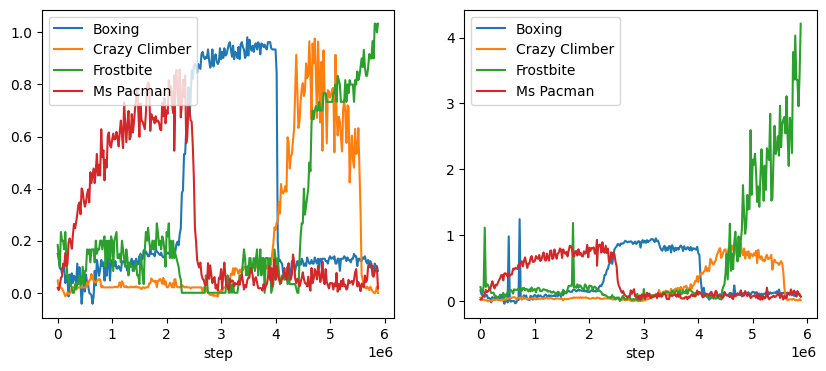

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

data.groupby(["env", "step"]).agg({
    "eval_score_norm": "median"
}).reset_index().set_index("step").groupby("env")["eval_score_norm"].plot(legend=True, ax=ax1)

data.groupby(["env", "step"]).agg({
    "eval_score_norm": "mean"
}).reset_index().set_index("step").groupby("env")["eval_score_norm"].plot(legend=True, ax=ax2)

plt.show()

In [35]:
data_step = data[["step", "env", "eval_score_norm"]].sort_values("step")
env_scores = data_step[data_step["env"] == "Ms Pacman"]

env_scores.head()

,step,env,eval_score_norm
0,1300,Ms Pacman,0.020661
23739,1300,Ms Pacman,0.000000
23741,1300,Ms Pacman,0.004132
23742,1300,Ms Pacman,0.033058
23745,1300,Ms Pacman,0.000000


In [36]:
windows = [(i * 100_000, i * 100_000 + 199_999) for i in range((5_880_000 + 99_999) // 100_000)]

smoothed = []

for env_name in env_names:
    for start_step, end_step in windows:
        env_scores = data_step[data_step["env"] == env_name]
        dist = env_scores[(env_scores["step"] >= start_step) & (env_scores["step"] <= end_step)]["eval_score_norm"]
        smoothed.append({
            "step": start_step,
            "eval_smooth_mean": np.mean(dist),
            "eval_smooth_sem": dist.sem(),
            "eval_smooth_q50": np.median(dist),
            "eval_smooth_qhi": np.percentile(dist, 75),
            "eval_smooth_qlo": np.percentile(dist, 25),
            "env": env_name,
        })

mp_s = pd.DataFrame(smoothed)

In [37]:
STEPS_PER_ENV = 4096 * 4 * 90

def start_step(i: int) -> int:
    steps = np.array(sorted(set(mp_s["step"])))
    target = STEPS_PER_ENV * i
    ge = steps >= target
    if ge.max() == 0:
        return steps.max()
    idx_hi = (steps >= target).argmax()
    if idx_hi == 0:
        return steps[idx_hi]
    diff_hi = steps[idx_hi] - target
    idx_lo = idx_hi - 1
    diff_lo = target - steps[idx_lo]
    if diff_hi < diff_lo:
        return steps[idx_lo]
    else:
        return steps[idx_hi]

def end_step(i: int) -> int:
    return start_step(i + 1)

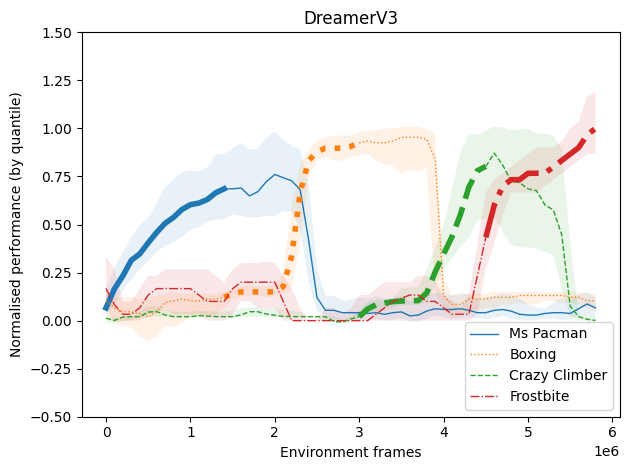

In [43]:
line_styles = ["solid", "dotted", "dashed", "dashdot"]

fig, ax = plt.subplots()

for colour, env_name, ls in zip(mpl_colours.TABLEAU_COLORS.keys(), env_names, line_styles):
    group = mp_s[mp_s["env"] == env_name]
    pos = env_names.index(env_name)
    start = start_step(pos)
    end = end_step(pos)
    where_bold = (group["step"] >= start) & (group["step"] <= end)
    group[where_bold].plot(
        ax=ax, kind="line", x="step", y="eval_smooth_q50", label="", linewidth=4, c=colour, ls=ls
    )
    # plt.plot(group["step"], group["eval_smooth_q50"], label=env_name, c=colour, ls=ls)
    pre = group[group["step"] <= start]
    post = group[group["step"] >= end]
    ax.plot(pre["step"], pre["eval_smooth_q50"], label=env_name, linewidth=1, c=colour, ls=ls)
    ax.plot(post["step"], post["eval_smooth_q50"], label="", linewidth=1, c=colour, ls=ls)
    plt.fill_between(
        group["step"],
        group["eval_smooth_qlo"],
        group["eval_smooth_qhi"],
        facecolor=colour,
        alpha=0.1,
    )

plt.xlabel("Environment frames")
plt.ylabel("Normalised performance (min-max scaled)")
plt.ylim(-0.5, 1.5)
plt.title("DreamerV3")
plt.legend(loc="lower right")

save("dreamer-v3")
plt.show()

In [39]:
mp_s

,step,eval_smooth_mean,eval_smooth_sem,eval_smooth_q50,eval_smooth_qhi,eval_smooth_qlo,env
0,0,0.105356,0.007688,0.066116,0.158058,0.024793,Ms Pacman
1,100000,0.200561,0.009762,0.165289,0.277893,0.086777,Ms Pacman
2,200000,0.277074,0.011227,0.233471,0.355372,0.158058,Ms Pacman
3,300000,0.351092,0.012190,0.314050,0.434917,0.217975,Ms Pacman
4,400000,0.393319,0.012283,0.347107,0.495868,0.266529,Ms Pacman
...,...,...,...,...,...,...,...
231,5400000,2.546854,0.224981,0.833333,0.933333,0.766667,Frostbite
232,5500000,2.651062,0.229000,0.866667,1.000000,0.800000,Frostbite
233,5600000,2.907839,0.281496,0.900000,1.033333,0.833333,Frostbite
234,5700000,3.347809,0.348199,0.966667,1.166667,0.866667,Frostbite


In [40]:
def compute_eos_eot() -> pd.DataFrame:
    end_train_stats = []
    for env_name in env_names:
        select_multi = mp_s[mp_s["env"] == env_name]
        pos = env_names.index(env_name)
        end = end_step(pos)
        final = end_step(len(env_names) - 1)

        # Print out extra stats
        end_stats = select_multi[select_multi["step"] == end]
        final_stats = select_multi[select_multi["step"] == final]
        end_train_stats.append({
            "env": env_name,
            "eos": end_stats["eval_smooth_mean"].item(),
            "eos_sem": end_stats["eval_smooth_sem"].item(),
            "eot": final_stats["eval_smooth_mean"].item(),
            "eot_sem": final_stats["eval_smooth_sem"].item(),
        })

    return pd.DataFrame(end_train_stats)

In [41]:
stats = compute_eos_eot()
stats

,env,eos,eos_sem,eot,eot_sem
0,Ms Pacman,0.732047,0.018672,0.101884,0.013871
1,Boxing,0.913288,0.005945,0.087969,0.007412
2,Crazy Climber,0.767007,0.018334,0.013850,0.002903
3,Frostbite,3.467460,0.516376,3.467460,0.516376


In [42]:
for _, row in stats.iterrows():
    env_name = row["env"]
    eos = row["eos"]
    eos_sem = row["eos_sem"]
    eot = row["eot"]
    eot_sem = row["eot_sem"]
    print(
        f"{env_name} & "
        f"${eos:.2f} \\pm {eos_sem:.2f}$ & ${eot:.2f} \\pm {eot_sem:.2f}$ \\\\"
    )

Ms Pacman & $0.73 \pm 0.02$ & $0.10 \pm 0.01$ \\
Boxing & $0.91 \pm 0.01$ & $0.09 \pm 0.01$ \\
Crazy Climber & $0.77 \pm 0.02$ & $0.01 \pm 0.00$ \\
Frostbite & $3.47 \pm 0.52$ & $3.47 \pm 0.52$ \\


```latex
\begin{table}[H]
    \caption{AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA. All metrics are average and standard errors over 5 seeds. EOS denotes the End Of Segment (i.e., where the bold segment ends in \autoref{fig:atari-plot}), and EOT denotes the End Of Training.}
    \label{tab:AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA}
    \centering
    \begin{tabular}{l l l}
        \toprule
        Environment & \multicolumn{2}{l}{DreamerV3} \\
                    & EOS  & EOT              
        \midrule
Ms Pacman & $0.73 \pm 0.02$ & $0.10 \pm 0.01$ \\
Boxing & $0.91 \pm 0.01$ & $0.09 \pm 0.01$ \\
Crazy Climber & $0.77 \pm 0.02$ & $0.01 \pm 0.00$ \\
Frostbite & $3.47 \pm 0.52$ & $3.47 \pm 0.52$ \\
        \bottomrule
    \end{tabular}
\end{table}
```